Name: **Chhavi Gupta**  
Email: `cgupta1_be21@thapar.edu`  
Roll No: **102103322**  
Group: **4CO12**  
Start Timestamp: 20240911-1000

## Question

Consider the paper: <https://arxiv.org/abs/1804.03209>

  1. Read and summarise the paper in about 50 words.
  2. Download the dataset in the paper, statistically analyse and
     describe it, so that it may be useful for posterity. (Include code
     snippets in your .ipynb file to evidence your analysis.)
  3. Train a classifier so that you are able to distinguish the commands
     in the dataset.
  4. Report the performance results using standard benchmarks.
  5. Record about 30 samples of each command in your voice and create a
     new dataset (including a new user id for yourself).  You may use a
     timer on your computer to synchronise.
  6. Fine tune your classifier to perform on your voice.
  7. Report the results.

## Paper Summary

The Speech Commands dataset contains 105,829 utterances of 35 words from 2,618 speakers, using hashed speaker IDs for privacy. It features a variety of background noise samples and supports automated and manual quality control methods. Evaluation metrics include Top-One Error and Streaming Accuracy, assessing model performance in keyword recognition and continuous audio streams. Version 2 improves accuracy over Version 1 and provides data for model optimization, noise tolerance, and application development. The dataset is accessible for reproducible research and diverse model benchmarking.
*italicized text*

## Solution

In [9]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [10]:
!pip install -U -q tensorflow tensorflow_datasets

In [12]:
DATASET_PATH = 'data/speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'speech_commands.tar.gz',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data/speech_commands')

2428923189/2428923189 ━━━━━━━━━━━━━━━━━━━━ 108s 0us/step


In [13]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != 'LICENSE')& (commands != '_background_noise_')& (commands != 'validation_list.txt')& (commands != 'speech_commands.tar.gz')& (commands != 'testing_list.txt')]
print('Commands:', commands)

Commands: ['forward' 'right' 'yes' 'no' 'left' 'off' 'happy' 'learn' 'four' 'sheila'
 'marvin' 'six' 'stop' 'nine' 'tree' 'two' 'up' 'dog' 'on' 'go' 'one'
 'down' 'follow' 'eight' 'three' 'zero' 'bird' 'seven' 'backward' 'house'
 'five' 'cat' 'wow' 'bed' 'visual']


In [14]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')
label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 105835 files belonging to 36 classes.
Using 84668 files for training.
Using 21167 files for validation.

label names: ['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


In [15]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [16]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [17]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [18]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [19]:
label_names[[1,2,3,4]]

array(['backward', 'bed', 'bird', 'cat'], dtype='<U18')

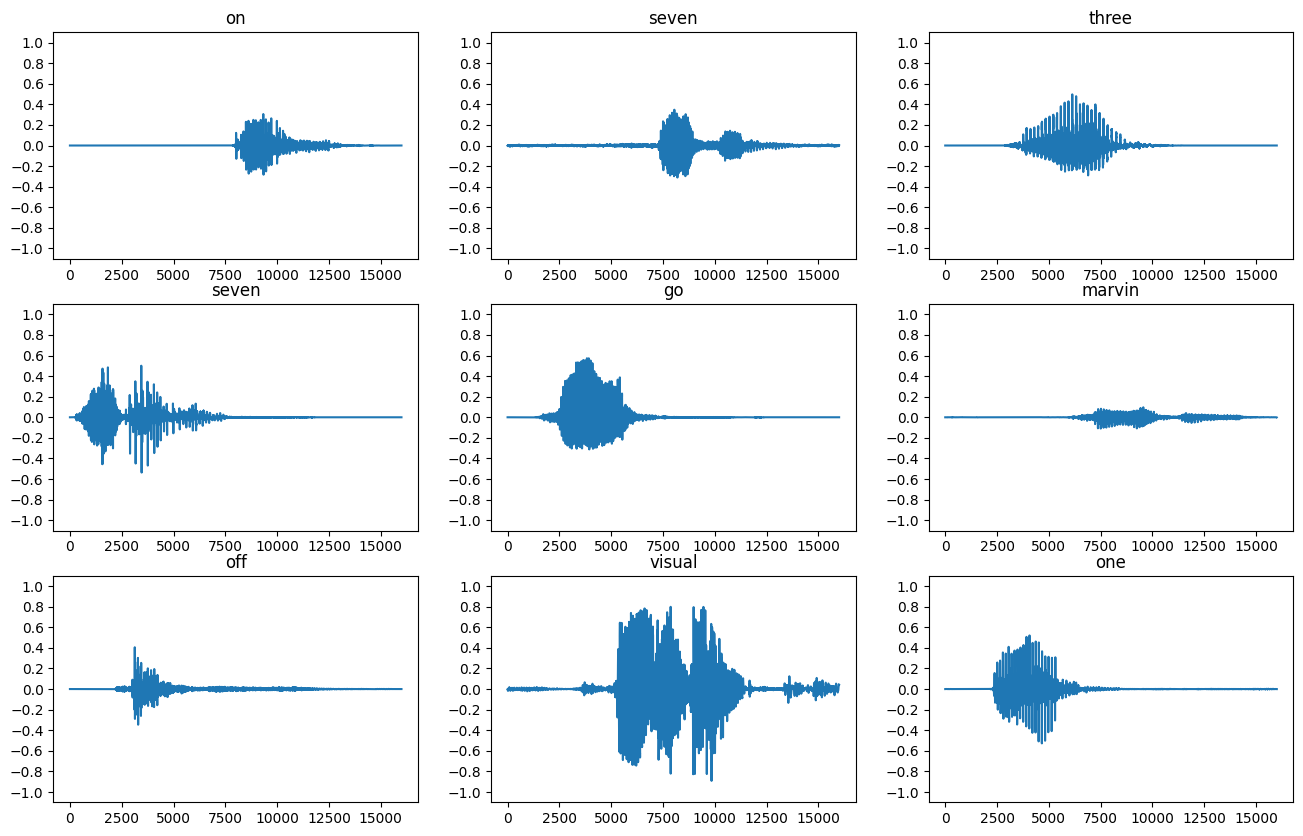

In [20]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [21]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [22]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)
  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: on
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: seven
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [23]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

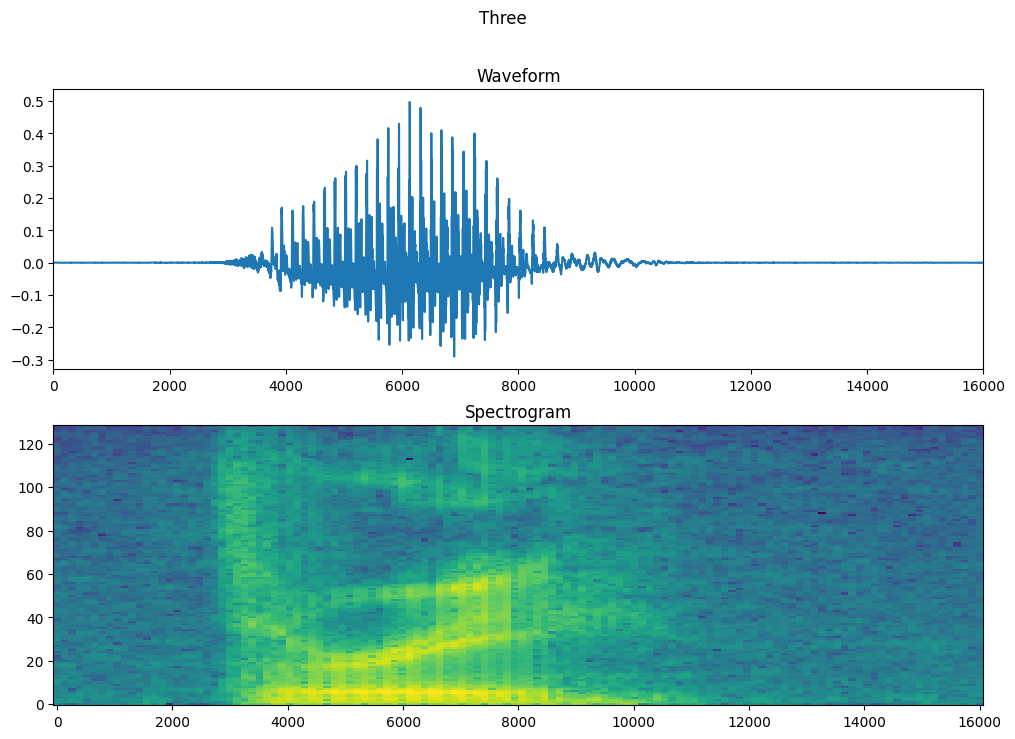

In [24]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [25]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [26]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [27]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

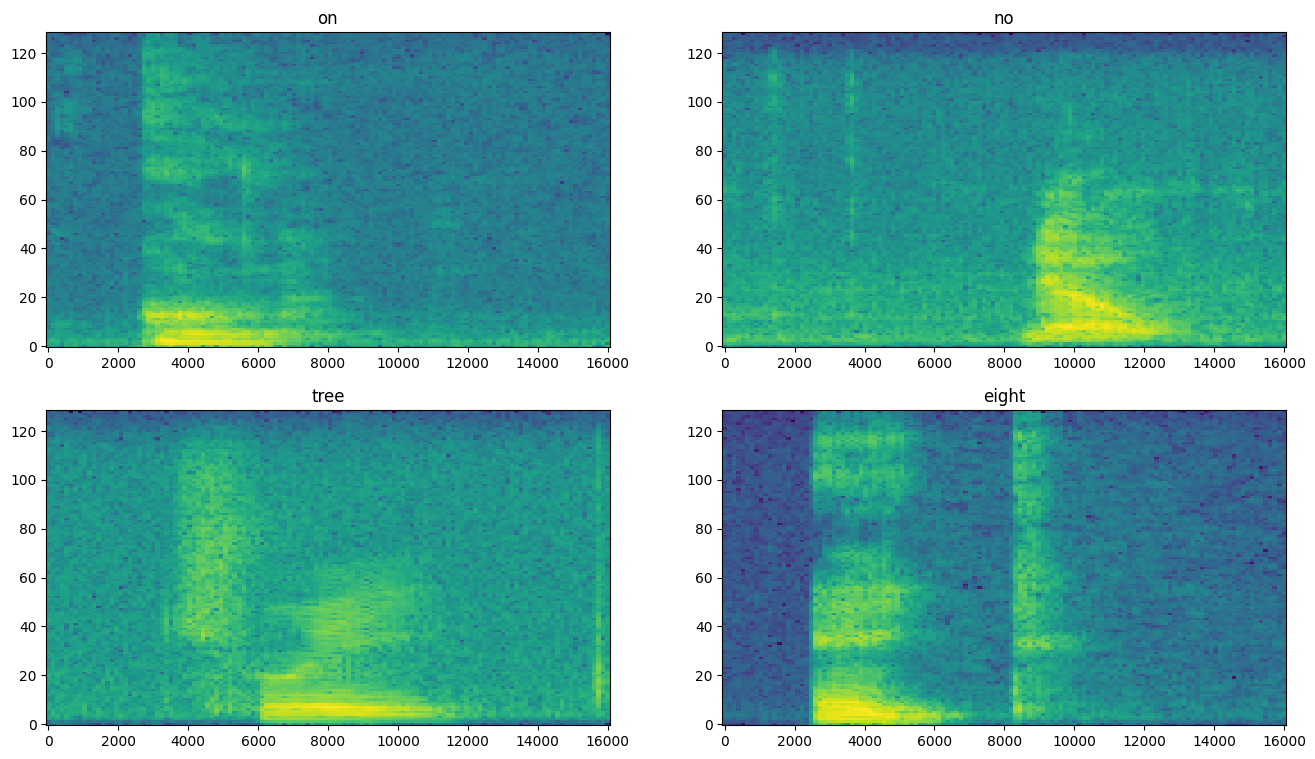

In [28]:
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [29]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [30]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │           4,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,629,223 (6.21 MB)

 Trainable params: 1,629,220 (6.21 MB)

 Non-trainable params: 3 (16.00 B)

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [32]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 58s 39ms/step - accuracy: 0.2478 - loss: 2.7235 - val_accuracy: 0.6754 - val_loss: 1.1698
Epoch 2/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5694 - loss: 1.4529 - val_accuracy: 0.7415 - val_loss: 0.9104
Epoch 3/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6505 - loss: 1.1816 - val_accuracy: 0.7764 - val_loss: 0.7871
Epoch 4/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6923 - loss: 1.0322 - val_accuracy: 0.8019 - val_loss: 0.6901
Epoch 5/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7211 - loss: 0.9262 - val_accuracy: 0.8076 - val_loss: 0.6691
Epoch 6/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7389 - loss: 0.8612 - val_accuracy: 0.8219 - val_loss: 0.6170
Epoch 7/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7539 - loss: 0.8113 - val_accuracy: 0.8223 - val_loss: 0.6040
Epoch 8/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7683 - loss: 0.7614 

Text(0, 0.5, 'Accuracy [%]')

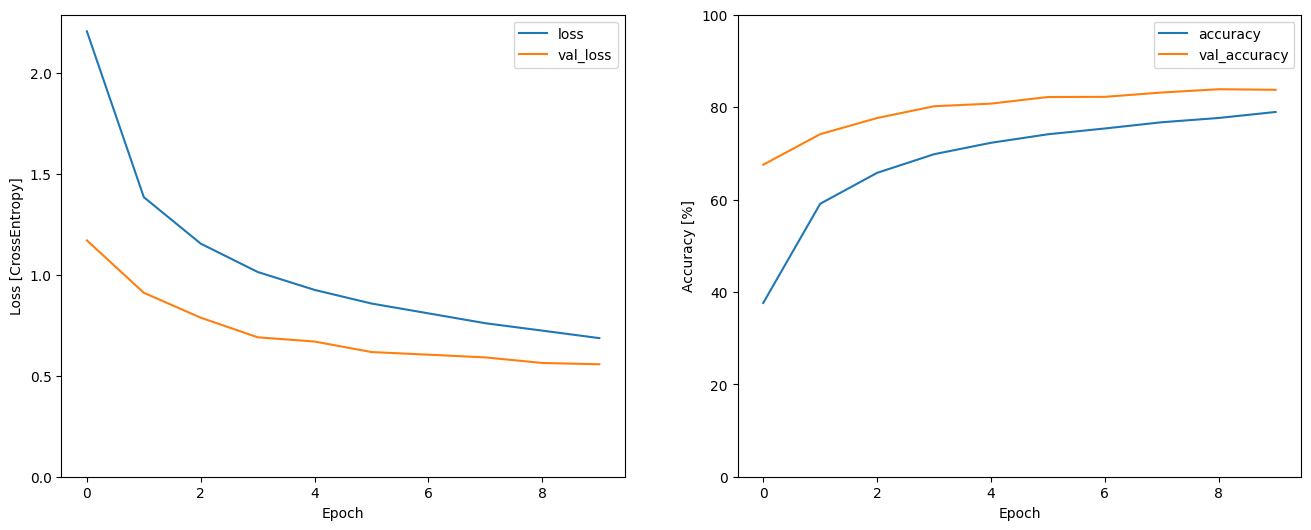

In [33]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [34]:
model.evaluate(test_spectrogram_ds, return_dict=True)

166/166 ━━━━━━━━━━━━━━━━━━━━ 25s 150ms/step - accuracy: 0.8436 - loss: 0.5392


{'accuracy': 0.8455736637115479, 'loss': 0.5361676812171936}

In [35]:
y_pred = model.predict(test_spectrogram_ds)

166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [36]:
y_pred = tf.argmax(y_pred, axis=1)

In [37]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

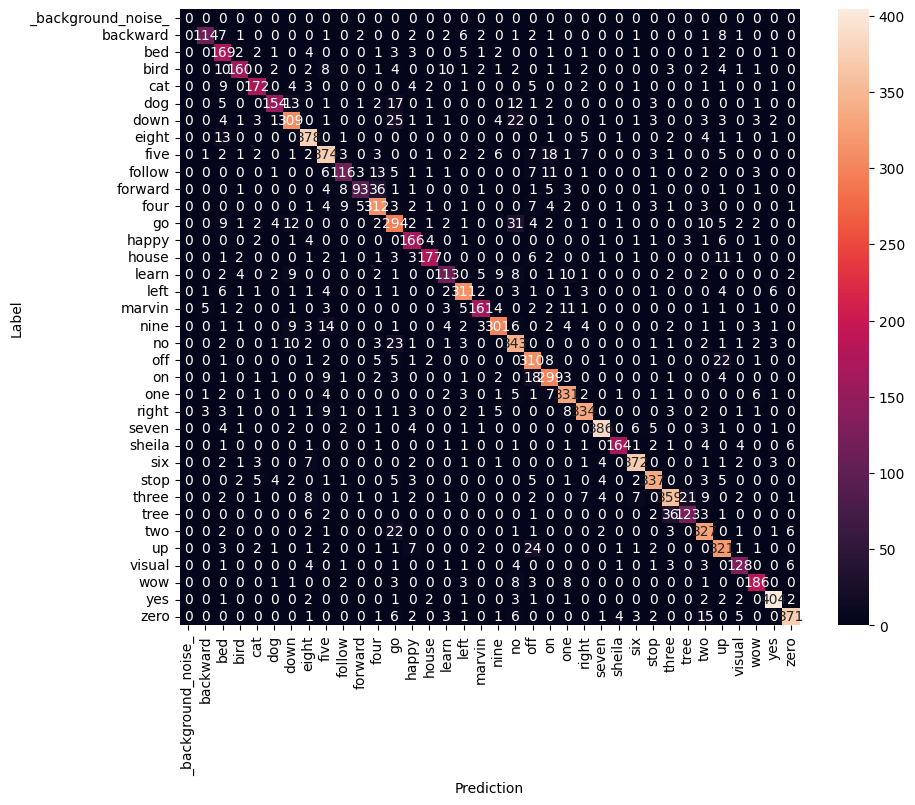

In [38]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

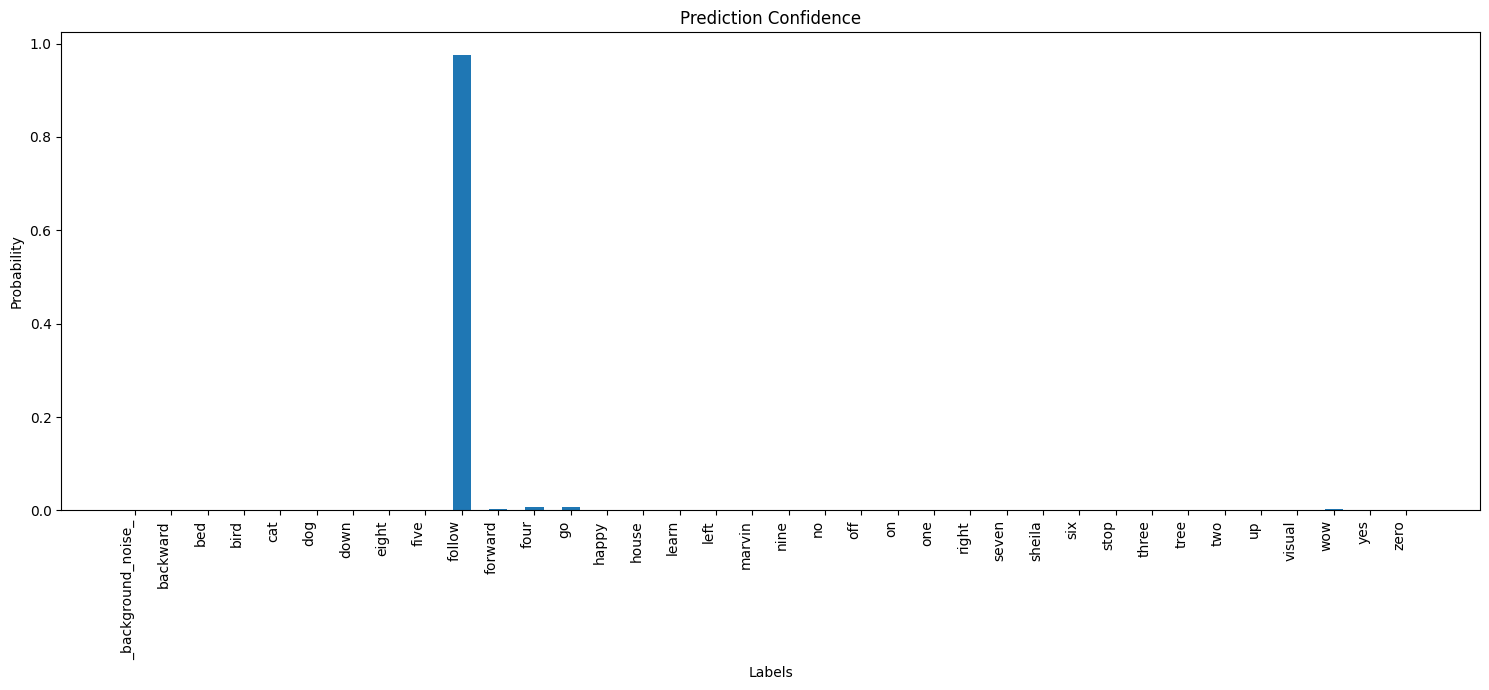

In [39]:
x = '/content/data/speech_commands/follow/067f61e2_nohash_1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1 )

# if tf.shape(x)[0] > 16000:
#     x = x[:16000]  # Trim to 1 second if too long
# elif tf.shape(x)[0] < 16000:
#     padding = tf.zeros([16000 - tf.shape(x)[0]])  # Pad if too short
#     x = tf.concat([x, padding], 0)

x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]


prediction = model(x)
x_labels = ['_background_noise_', 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight',
 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left',
 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six',
 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


plt.figure(figsize=(15, 7))
plt.bar(x_labels, tf.nn.softmax(prediction[0]), width=0.5)
plt.xticks(rotation=90, ha='right')
plt.title('Prediction Confidence')
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.tight_layout()
plt.show()
#display.display(display.Audio(waveform, rate=sample_rate))
display.display(display.Audio(waveform.numpy(), rate=sample_rate.numpy()))

In [40]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):

    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [41]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 36), dtype=float32, numpy=
 array([[-26.20869   , -11.176617  ,  -5.296423  ,  -5.381374  ,
         -10.385016  ,   0.55017304,   2.856034  ,  -7.684065  ,
         -10.025663  ,  -3.1587358 ,  -8.59564   ,  -4.4509954 ,
           4.723272  , -12.745137  ,  -5.5599813 ,   1.3168707 ,
          -6.790875  ,  -5.800913  ,  -1.4690623 ,   5.906163  ,
         -10.983715  ,  -7.924755  ,  -7.0115542 ,  -8.526614  ,
          -8.29374   ,  -6.5161657 , -12.239129  ,  -5.0378523 ,
          -8.772978  , -11.299422  ,  -0.47038698,  -8.243514  ,
          -1.5370237 ,   0.74229527,  -1.968295  ,   0.4536962 ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([19])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [42]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'predictions': <tf.Tensor: shape=(1, 36), dtype=float32, numpy=
 array([[-27.92353   , -10.780142  ,  -6.7729025 ,  -5.8712416 ,
         -12.470056  ,   1.8777329 ,   0.18065287,  -9.670943  ,
           0.4456573 ,   8.851723  ,   3.2019012 ,   4.0193496 ,
           3.8304675 , -16.22949   ,  -4.1414366 ,  -4.6747966 ,
         -16.754496  ,  -7.4230866 , -10.437619  ,  -3.3101532 ,
          -0.20287077,   2.403879  ,  -8.246283  , -13.386535  ,
          -6.3965607 ,  -9.373136  , -18.176718  ,  -2.1772804 ,
         -11.511581  , -14.592415  ,  -3.6291573 ,  -4.0988383 ,
          -6.455507  ,   3.356324  , -15.496532  ,  -7.1160975 ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([9])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'follow'], dtype=object)>}

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
my_voice_ds, my_voice_val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='/content/drive/MyDrive/Speech_LE1/mydata',
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=40000,
    subset='both')

Found 1065 files belonging to 36 classes.
Using 852 files for training.
Using 213 files for validation.


In [45]:
my_voice_ds = my_voice_ds.map(squeeze, tf.data.AUTOTUNE)
my_voice_val_ds = my_voice_val_ds.map(squeeze, tf.data.AUTOTUNE)
my_voice_spectrogram_ds = make_spec_ds(my_voice_ds)
my_voice_val_spectrogram_ds = make_spec_ds(my_voice_val_ds)



In [47]:
history_fine_tuned = model.fit(
    my_voice_spectrogram_ds,
    validation_data=my_voice_val_spectrogram_ds,
    epochs=15,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)



Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 464ms/step - accuracy: 0.8524 - loss: 0.4950 - val_accuracy: 0.9531 - val_loss: 0.1957
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 583ms/step - accuracy: 0.8586 - loss: 0.5138 - val_accuracy: 0.9624 - val_loss: 0.1731
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 672ms/step - accuracy: 0.8859 - loss: 0.4147 - val_accuracy: 0.9718 - val_loss: 0.1473
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 460ms/step - accuracy: 0.9067 - loss: 0.3711 - val_accuracy: 0.9765 - val_loss: 0.1185
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 425ms/step - accuracy: 0.8975 - loss: 0.3285 - val_accuracy: 0.9812 - val_loss: 0.1077
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - accuracy: 0.9169 - loss: 0.3057 - val_accuracy: 0.9765 - val_loss: 0.0920
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 420ms/step - accuracy: 0.9259 - loss: 0.2580 - val_accuracy: 0.9624 - val_loss: 0.1109
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.9143 - loss: 0.2730 - val_accuracy: 

In [48]:
model.evaluate(my_voice_val_spectrogram_ds, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.9962 - loss: 0.0501


{'accuracy': 0.9906103014945984, 'loss': 0.06075087562203407}